In [1]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, FFMpegWriter, PillowWriter
import numpy as np
from numpy.random import normal, uniform
from numba import njit
from tqdm import tqdm
import jax
from jax import vmap, jit
import jax.numpy as jnp
from jax.config import config
from scipy.optimize import curve_fit
from scipy.stats import qmc
from scipy.stats.qmc import LatinHypercube as LHS

def memory(a):
    print("Used {}Mb".format(int(a.size*a.itemsize//1e6)))

plt.rcParams["figure.figsize"] = [10, 10]
np.set_printoptions(suppress=True, edgeitems=15, precision=4)
jnp.set_printoptions(suppress=True, edgeitems=15, precision=4)
config.update("jax_enable_x64", True)
plt.rcParams["lines.linewidth"] = 2
plt.rcParams["figure.dpi"] = 100 
plt.style.use(['dark_background'])
#plt.style.use(['seaborn-notebook'])
#plt.style.available

# Teori
Lennard-Jones-potentialen definieras som:
$$ V(r) = 4\varepsilon \left( \left(\sigma / r\right)^{12} - \left(\sigma / r\right)^6 \right)$$
Kraften som partiklarna påverkas av ges av   
$$ F(r_i, r_j) = -\nabla V = 24\varepsilon \sigma^6 \left[  \frac{2\sigma^6}{ {\left| r_i - r_j \right|}^{13} }  - \frac{1}{{\left| r_i - r_j \right|}^{7}} 
\right]
\frac{r_i - r_j}{\left|r_i - r_j\right|}$$
Man kan skriva det här i ett mer numeriskt stabilt sätt om $\sigma=2^{1/6}r$
$$
F(r_i, r_j) = 
\left(\frac{3\varepsilon}{28r^2} \right) \cdot 
\left(\frac{2r}{\left| r_i - r_j \right|} \right)^{14} \cdot 
\left(r_i - r_j\right) - 
\left(\frac{3\varepsilon}{16r^2} \right) \cdot \left(\frac{2r}{\left| r_i - r_j \right|} \right)^8 \cdot
\left(r_i - r_j \right)
$$

# CPU implementation
Implementation med NumPy + numba och JAX. Antalet partiklar tas bort från simuleringen när de lämnar systemet.
Detta ger fördelen att simuleringe har körs snabbar ju längre den håller på. Dock har den dålig egenskap för parallellism 
och det krävs en extra for-loop vilket kan bli dyrt om man vill ha flera oberoende simuleringar.
Koden kan köra på ett par minuter på en CPU.\
Följande implementation användes för att generera resultaten i rapporten.

In [13]:
np.random.seed(0)

# behållarens dimensioner
x1, x2, y1, y2 = -100, 100, -100, 100

n_simulations = 1  # antalet gånger som simuleringen upprepas (bäst då den är n_particles^2)
n_particles = 1500 # antalet partiklar
radius = 0.02 * x2 # normaliserad radie 
eps = 4000         # minstan värde på potentialen
m = 1e4            # massan
dt = 1e-6          # tids-steg
frames = 700       # frames som visas i animeringen
time_factor = 10   # lagrar datan för vart "time_factor"-gång
time_steps = time_factor * frames # totala simuleirngs tiden
    
# lagra data
r_evolve = []
T_evolve = np.zeros([n_simulations, frames])
particle_count = np.zeros([n_simulations, frames])

In [14]:
@jit
def distance_matrix(r): 
    """
    wrapping the inner function "_distance_matrix" to simpliy the input parameter
    """ 
    def _distance_matrix(r, ri): 
        """
        multi target distances: Computes the distances for a (n_particles, 2) array
        returns (n_particles, n_particles) array with the diagonal elements equal to zero
        """
        def distance_fn(r): 
            """
            single target distance: Computes the distance for one particle 
            with respect to every other.
            returns (0, r1, r2, ..., rn) array
            """
            return jnp.linalg.norm(r - ri, axis=-1)

        return vmap(distance_fn)(r)

    return _distance_matrix(r, r)

@njit
def collision_indices(D, radius):
    """
    Computing the indices for the r = (n_paritcles, 2) array which the particles collide.
    This is done by stripping away some less important values so the algorithm runs faster.
    idx1, idx2: (i,), (i,) where i << n since only a small portion of the particles "collide"
    """
    cond = (0.0 < D) & (D < 2 * radius) 
    idx1, idx2 = np.where(cond)
    return idx1, idx2

@njit
def F(s):
    """
    Computing the force given the separation vectros between the particles
    F: s -> (n_particles, 2) 
    """
    R = np.sqrt(np.sum(s**2, axis=-1))
    R = np.clip(R, a_min=0.01*radius, a_max=2*radius)
    F = ((3*eps/(28*radius**2)) * (2*radius/R)**14 - (3*eps/(16*radius**2)) * (2*radius/R)**8) * s.T 
    F = np.clip(F, a_min=15*x1/dt, a_max=15*x2/dt)
    return F.T


@njit
def wall_collision(r, v):
    """
    Computes the valocities ater the collision with the wall.
    The collition condition is when the coordinate of the particles is smaller/larger
    than some certain threshold. 
    """
    x, y = r[...,0], r[...,1]
    vx, vy = v[...,0], v[...,1]
    
    vx[x > (x2 - radius/2)] = -np.abs(vx[x > (x2 - radius/2)]) # reflection against the right wall
    vx[x < (x1 + radius/2)] =  np.abs(vx[x < (x1 + radius/2)]) # reflection against the left wall
    vy[y < (y1 + radius/2)] =  np.abs(vy[y < (y1 + radius/2)]) # reflection against the bottom wall
    return vx, vy

@njit
def internal_temperature(v, t):
    """
    Computing the temperature inside the box by 
    computing the average kinetic energy
    """
    v_norm = v / v0
    T = np.mean(v_norm**2)
    return T    

@njit
def Langevin_force(v, t):
    """
    Some normal distributed force which inceases 
    if temperature of the system inceases.
    """
    T = internal_temperature(v, t) 
    F = np.sqrt(T) * np.random.normal(0, 1, size=v.shape)     
    return 10 * F

In [15]:
for n in range(n_simulations): # looping over the independent simulations
    
    # using Latin hypercube sampling to generate initial position
    r = LHS(2, seed=n).random(n_particles) 
    r = x2 * (2 * r - 1)
    
    # initiating the velcity and gravitation
    v0 = 100 * x2
    v = 0 *v0 * normal(0, 1, size=[n_particles, 2]) 
    g = 9.82 * x2 * np.ones([n_particles, 2])
    g[:,0] = 0.0
    
    # simulation loop
    for t in tqdm(range(time_steps)):
        # computing the distances between each particles 
        D = np.asarray(distance_matrix(r)) 
        
        # computing the indices of the matrix 
        # for which the distance are > 0 and < 2*radius
        idx1, idx2 = collision_indices(D, radius) 

        if len(idx1): # if any particles collide
            s = r[idx1] - r[idx2] # computing the separation vector
            # updating the velocity using Euler's method 
            dv = F(s) * dt  
            v[idx1] += dv # updating the valodicies o the particles which collides
            v[idx1] *= 0.9999 # damping

        # checking for wall collision
        vx, vy = wall_collision(r, v)
        v = np.c_[vx, vy] - m * g * dt + Langevin_force(v, t)
        r += v * dt
           
        if t % time_factor == 0: 
            # decreasing the size of the arrys when particles are outside the domain
            particles_inside = r[...,1] < y2
            r = r[particles_inside]
            v = v[particles_inside]
            g = g[particles_inside]
            
            # storing some useful information
            r_evolve.append(r)
            particle_count[n, t//time_factor] = len(r)
            T_evolve[n, t//time_factor] = internal_temperature(v, t)
        
    print(f"simulation {n} finished")
    del r, v, g, D # free up the memory
    
print(f"all {n_simulations} completed")

100%|██████████| 7000/7000 [01:16<00:00, 91.79it/s] 

simulation 0 finished
all 1 completed


## Dataanalys

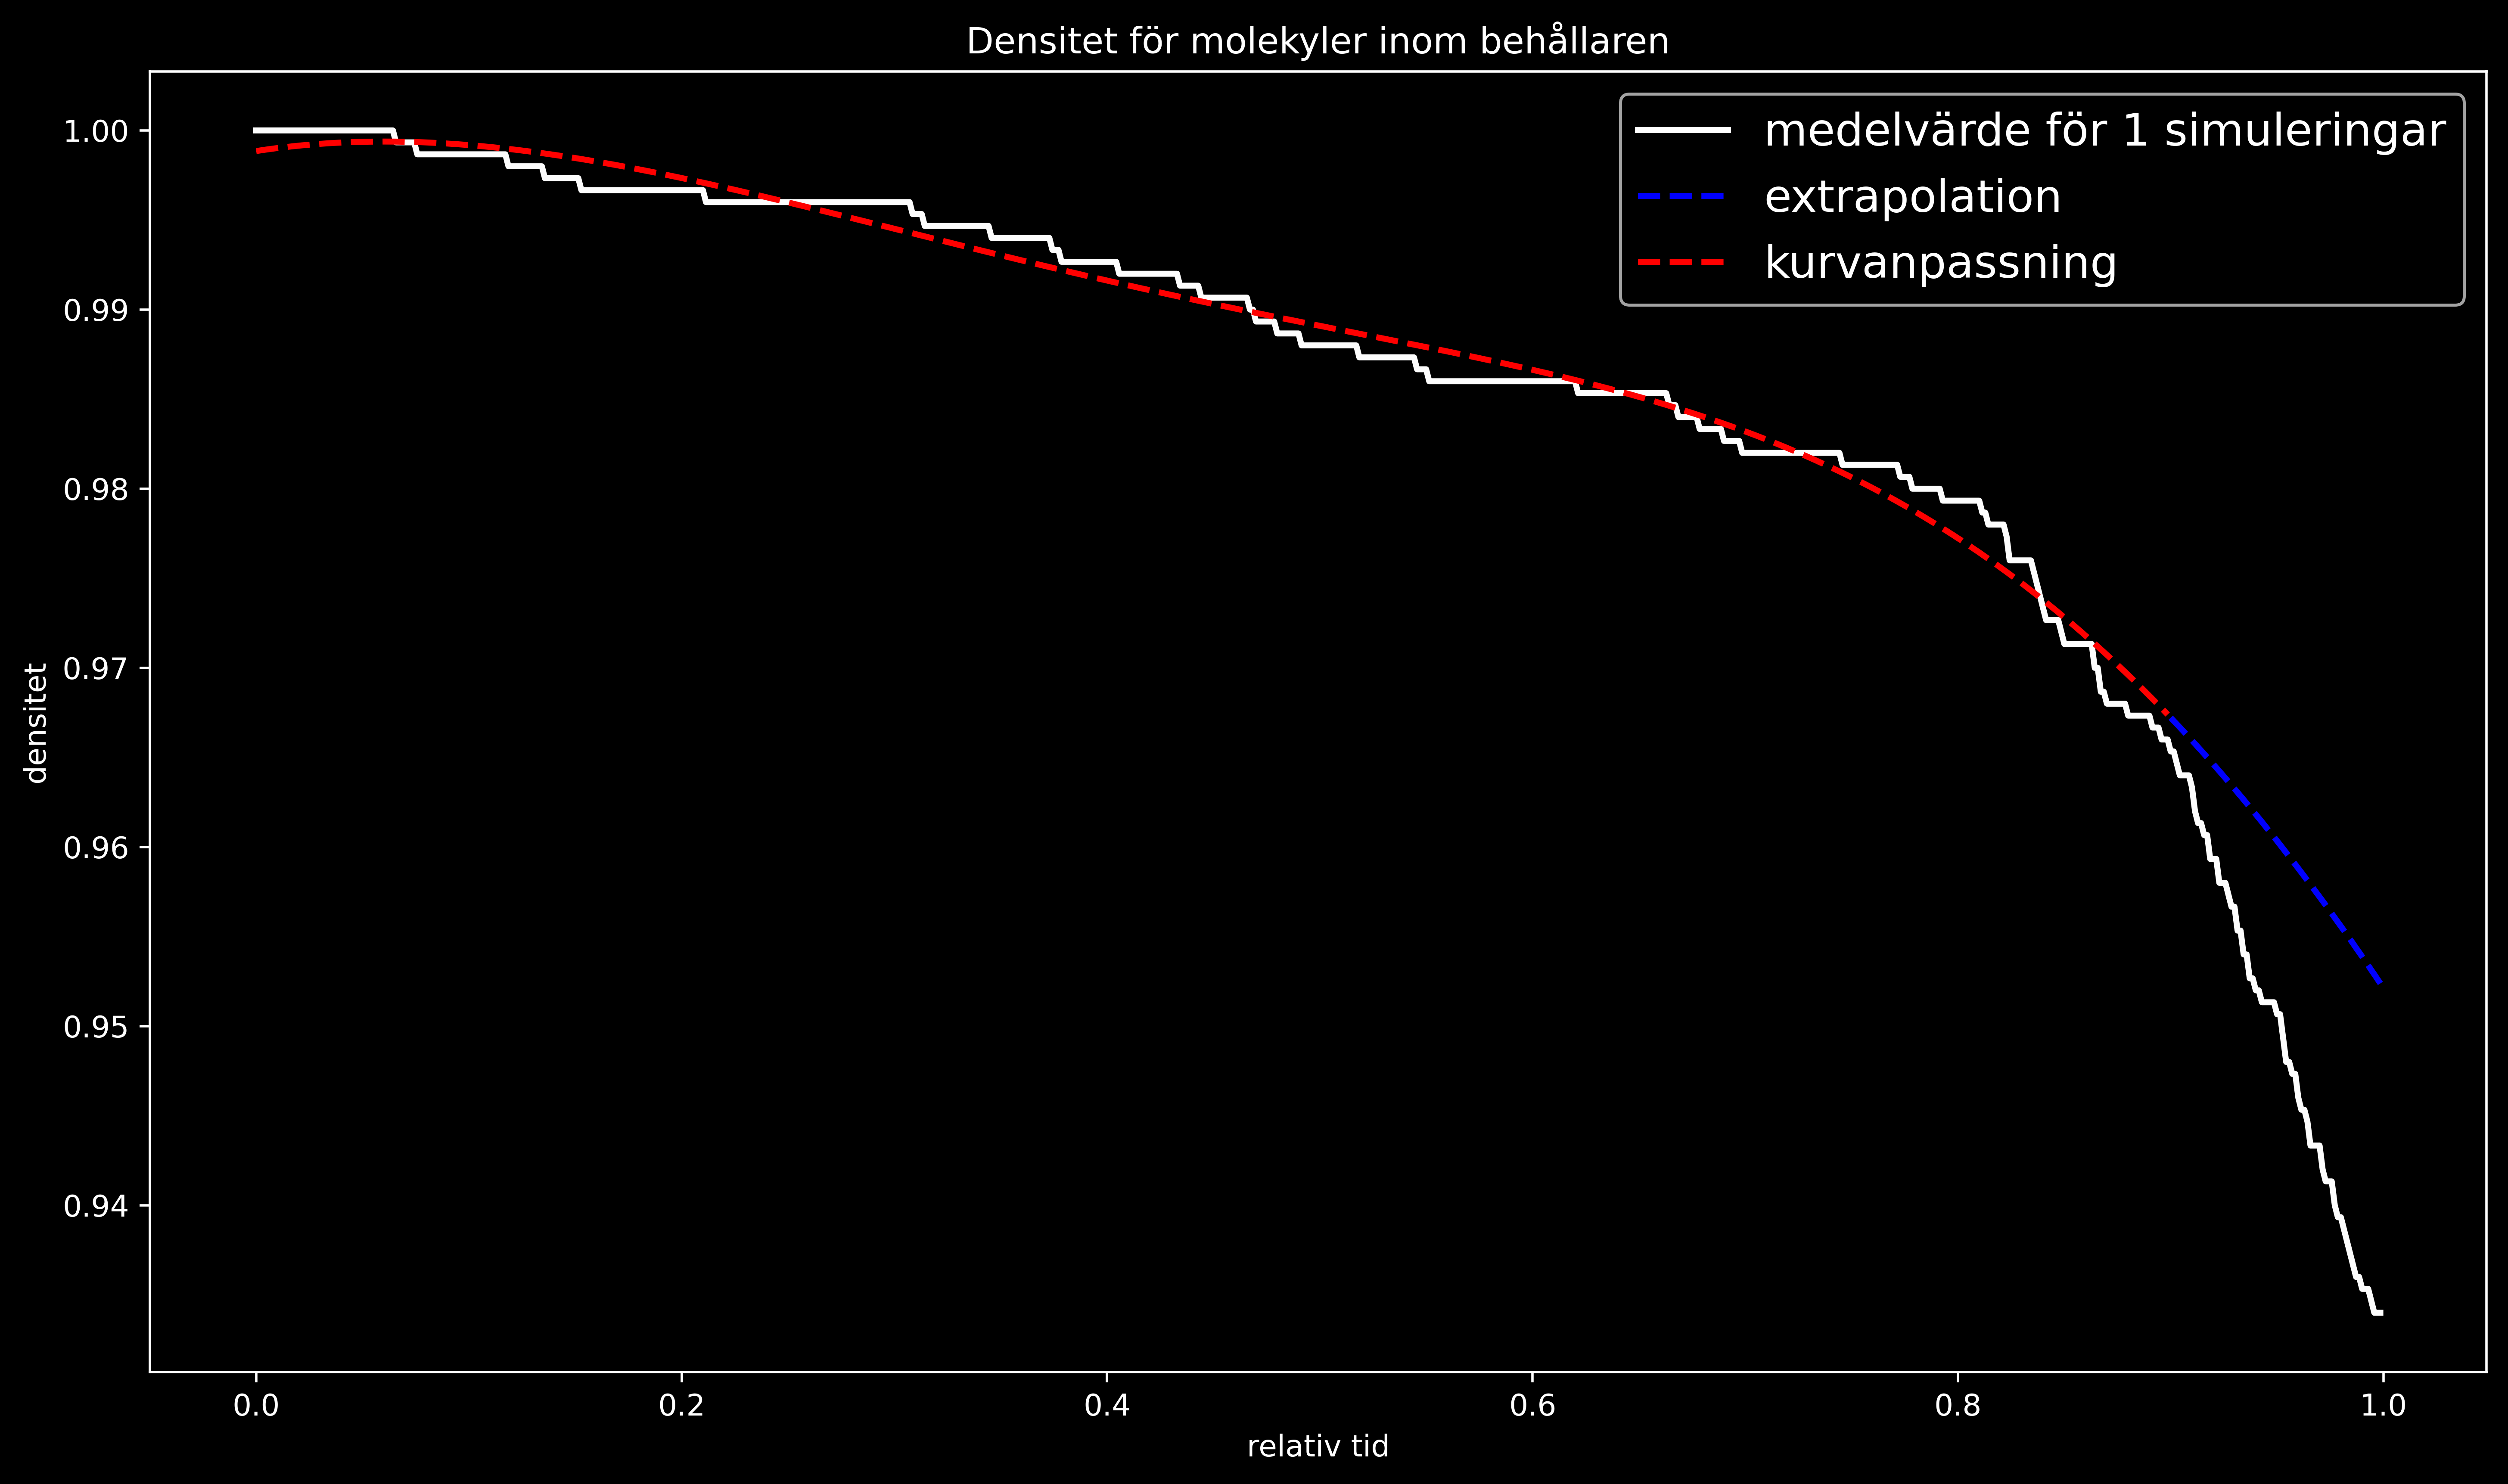

In [21]:
def fit(x, a, b, c, d, e, f):
    return a*np.exp(-b*x) + c*np.exp(-d*x**2) + e*np.exp(-f*x**3) 

cutoff = 0
y = particle_count.mean(0)[cutoff:] / n_particles
x = np.arange(cutoff, frames) / frames
x_fit = x[:-frames//10]
y_fit = y[:-frames//10]

popt, pcov = curve_fit(fit, x_fit, y_fit)

plt.figure(figsize=(14, 8), dpi=500)
plt.title("Densitet för molekyler inom behållaren")

plt.errorbar(x, y, 
             yerr=2*particle_count.std(0)[cutoff:]/np.sqrt(n_simulations)/n_particles, 
             alpha=0.01, color="grey")

plt.plot(x, y, "-", color="white", label=f"medelvärde för {n_simulations} simuleringar") # light green
plt.plot(x[-frames//10:], fit(x[-frames//10:], *popt), "--", color="blue", label="extrapolation")
plt.plot(x_fit, fit(x_fit, *popt), "--", color="red", label="kurvanpassning")

plt.xlabel("relativ tid"), plt.ylabel("densitet")
plt.legend(fontsize=15)
#plt.savefig("hel 4 simuleringar med 1500 partiklar tid=50000.png")
#np.save("4 simuleringar med 1500 partiklar tid=50000", particle_count)

# Visualisering

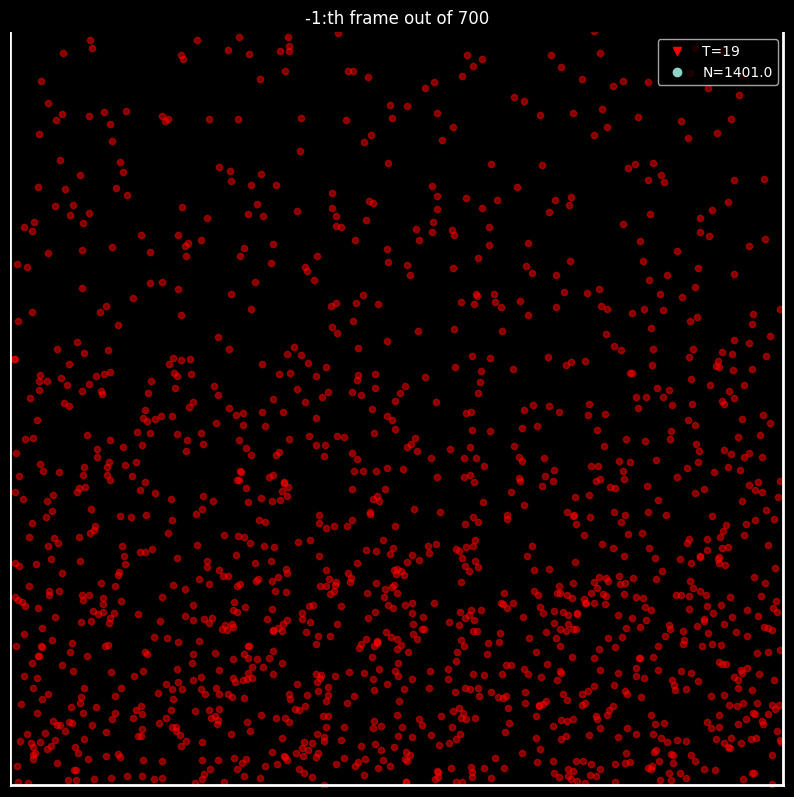

In [16]:
class Scene:
    def __init__(self, i=0, 
                 r_evolve=r_evolve, T_evolve=T_evolve,
                 x1=x1, x2=x2, y1=y1, y2=y2,
                 color="red", figsize=(10, 10), dpi=100):     
        
        self.i = i # current frame: default is first frame
        self.x1 = x1
        self.x2 = x2
        self.y1 = y1
        self.y2 = y2
        self.r_evolve = r_evolve
        self.T_evolve = T_evolve
        self.radius = 225*radius/self.x2

        self.color = color
        self.position = "upper right"
        self.fig, self.ax = plt.subplots(figsize=figsize, dpi=dpi)
        
    def box(self, color="white", axis="off"):
        
        self.ax.plot(2*[self.x1], [self.y1, self.y2], color=color)
        self.ax.plot(2*[self.x2-self.x2/200], [self.y1, self.y2], color=color)
        self.ax.plot([self.x1, self.x2-self.x2/200], 2*[self.y1+self.y2/200], color=color)
        self.ax.axis([self.x1, self.x2, self.y1, self.y2])
        self.ax.axis(axis)
        return self.ax
        
    def particles(self, alpha=0.5): 
        
        x, y = np.asarray(self.r_evolve[self.i]).T
        self.ax.plot(x, y, "o", ms=self.radius, alpha=alpha, color=self.color)
        self.ax.plot([],[], "o", label="N={}".format(particle_count[0][self.i]))
        self.ax.legend(loc=self.position)
        return self.ax
        
    def temperature(self): 
        self.ax.plot([],[], "v", 
                     color=self.color, 
                     label="T={}".format(int(self.T_evolve[0][self.i])))
        self.ax.legend(loc=self.position)
        return self.ax
    
    def __call__(self, i):
        self.i = i
        self.ax.set_title(f"{self.i}:th frame out of {len(self.r_evolve)}")
        self.temperature()
        self.particles()
        self.box()
        return self
    
        
scene = Scene()
scene(-1)

## Animering
Skapar en film i mp4-format med "frames" antal frames.

3%
6%
9%
11%
14%
17%
20%
23%
26%
29%
31%
34%
37%
40%
43%
46%
49%
51%
54%
57%
60%
63%
66%
69%
71%
74%
77%
80%
83%
86%
89%
91%
94%
97%


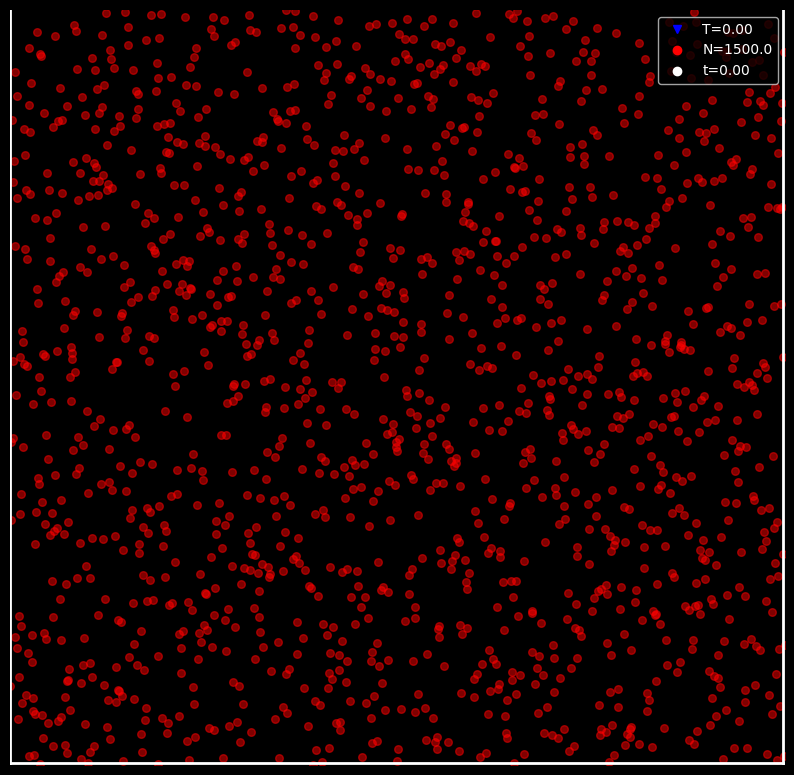

In [17]:
color = "white"
fig, ax = plt.subplots(figsize=(10, 10), dpi=100)

def animate(i):
    ax.clear()
    if i % 20 == 0 and i != 0: 
        print("{:.0f}%".format(100*i/frames))

    # particles
    x, y = np.asarray(r_evolve[i]).T
    ax.plot(x, y, "ro", ms=550*radius/x2/2, alpha=0.5)
    
    # info about the state
    plt.plot([],[],"bv", label="T={:.2f}".format(T_evolve[0][i]))
    plt.plot([],[],"ro", label="N={}".format(particle_count[0][i]))
    plt.plot([],[],"wo", label="t={:.2f}".format(100*i/frames))
    plt.legend(loc="upper right")
    
    # box
    ax.plot(2*[x1], [y1, y2], color=color)
    ax.plot(2*[x2-x2/200], [y1, y2], color=color)
    ax.plot([x1, x2-x2/200], 2*[y1+y2/200], color=color)
    ax.axis([x1, x2, y1, y2])
    ax.axis("off")

writer = FFMpegWriter(fps=30) # PillowWriter(fps=30) använd det här för att skapa en gif
ani = FuncAnimation(fig, 
                    animate, 
                    frames=frames)
ani.save('Particle interactions video.mp4', writer=writer)

# GPU compatibelt kod
Denna implementation simulerar alla partiklar genom hela simuleringen till skillnad från CPU implementationen 
som kraftigt reducerar beräkningarna genom att bara simulera de partiklar som kolliderar (befinner sig inom ett avstånd som är mindre än 2 * radius). Den har dock samma komplexitivitet som CPU implementationen men p.g.a. optimeringar för parallellism så kan den köras 30 gånger snabbare. Resultaten är dock inte helt ekvivalenta eftersom denna implemntation 
introducerar dämpning för alla partiklar (istället för de som bara kolliderar i förgående fall). Systemet beter sig då kvalitativt annorlunda.

In [2]:
np.random.seed(0)
key = jax.random.PRNGKey(0)

# domain
x1, x2, y1, y2 = -100, 100, -100, 100

n_simulations = 1  # number of repeated simulations (for reducing standard error)
n_particles = 1500 # number of particles
radius = 0.02 * x2 # normalized radius 
eps = 4000         # minimal value of the potential
m = 1e4            # mass, dont bother about the unit
dt = 1e-6  
frames = 500     # frames displayed for the plots
time_factor = 10   # storing the data every 10 loops
time_steps = time_factor * frames # total simulation time

r = np.random.uniform(x1, x2, size=(n_simulations, n_particles, 2))
r = jnp.array(r)

# initiating the velcity and gravitation
v0 = 100 * x2
v = 0 * v0 * jax.random.normal(key, shape=[n_simulations, n_particles, 2]) 
g = 9.82 * x2 * jnp.ones([n_simulations, n_particles, 2])
g = g.at[...,0].set(0.0)

normal_dist = jax.random.normal(key, shape=(frames, *v.shape))  

2022-10-25 08:20:11.436892: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2022-10-25 08:20:11.548630: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2022-10-25 08:20:11.628242: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to 

In [3]:
@jit
def sep_vec(r):
    def _sep_vec(r, ri):
        def inner(r):
            return r - ri 
        return vmap(inner)(r)
    return vmap(_sep_vec)(r, r)

@jit
def F(s):
    R = jnp.sqrt(jnp.sum(s**2, axis=-1, keepdims=True))
    R = jnp.clip(R, a_min=0.01*radius, a_max=jnp.inf)
    R = R.at[:, jnp.arange(n_particles), jnp.arange(n_particles), :].set(jnp.inf)
    F = ((3*eps/(28*radius**2)) * (2*radius/R)**14 - (3*eps/(16*radius**2)) * (2*radius/R)**8) * s 
    F = jnp.clip(F, a_min=50*x1/dt, a_max=50*x2/dt).sum(-2)
    return F

# @njit
def wall_collision(r, v):
    x, y = r[...,0], r[...,1]
    vx, vy = v[...,0], v[...,1]

    vx[x > (x2 - radius/2)] = -np.abs(vx[x > (x2 - radius/2)])
    vx[x < (x1 + radius/2)] =  np.abs(vx[x < (x1 + radius/2)])
    vy[y < (y1 + radius/2)] =  np.abs(vy[y < (y1 + radius/2)])
    return np.c_[vx[...,None], vy[...,None]]

@jit
def internal_temperature(v):
    v_norm = v / v0
    T = jnp.mean(v_norm**2, -1, keepdims=True).mean(-2, keepdims=True)
    return T   

@jit
def Langevin_force(v, t):
    T = internal_temperature(v) 
    F = jnp.sqrt(T) * normal_dist[t]    
    return F

@jit
def update_v(v, t):
    return 0.9999*(v - m * g * dt + Langevin_force(v, t))

In [4]:
# empty array/list for storing stuff
r_evolve, T_evolve, particle_count = [], [], []

# simulation loop
for t in tqdm(range(time_steps)):
    s = sep_vec(r)
    dv = F(s) * dt  
    v = dv + update_v(v, t)

    # checking for wall collision
    v = wall_collision(np.array(r), np.array(v))
    r += v * dt
    
    if t % time_factor == 0: 
        _r = np.array(r)
        _T = np.array(internal_temperature(v)[0])
        
        particles_inside = _r[...,1] < y2
        r_evolve.append(_r)
        particle_count.append(_r[particles_inside].shape[0])
        T_evolve.append(_T)

print(f"simulation finished")

  0%|          | 0/30000 [00:00<?, ?it/s]2022-10-25 08:20:13.103670: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2022-10-25 08:20:13.308213: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2022-10-25 08:20:13.310166: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is 

simulation finished


In [ ]:
color = "white"
fig, ax = plt.subplots(figsize=(10, 10), dpi=200)
data = np.array(r_evolve).reshape(n_simulations, frames, n_particles, 2)
temperature = np.array(T_evolve)[...,0].flatten()
particles = np.array(particle_count)

def animate(i):
    ax.clear()
    if i % 20 == 0 and i != 0: 
        print("{:.0f}%".format(100*i/frames))

    # particles
    x, y = data[0][i].T
    ax.plot(x, y, "ro", ms=550*radius/x2/2, alpha=0.5)
    
    # info about the state
    plt.plot([],[],"bv", label="T={:.2f}".format(temperature[i]))
    plt.plot([],[],"ro", label="N={}".format(particles[i]))
    plt.plot([],[],"wo", label="t={:.2f}".format(100*i/frames))
    plt.legend(loc="upper right")
    
    # box
    ax.plot(2*[x1], [y1, y2], color=color)
    ax.plot(2*[x2-x2/200], [y1, y2], color=color)
    ax.plot([x1, x2-x2/200], 2*[y1+y2/200], color=color)
    ax.axis([x1, x2, y1, y2])
    ax.axis("off")

writer = FFMpegWriter(fps=30, bitrate=-1)
ani = FuncAnimation(fig, 
                    animate, 
                    frames=frames)
ani.save('Particle interactions video.mp4', writer=writer)

1%
1%
2%
3%
3%
4%
5%
5%
6%
7%
7%
8%
9%
9%
10%
11%
11%
12%
13%
13%
14%
15%
15%
16%
17%
17%
18%
19%
19%
20%
21%
21%
22%
23%
23%
24%
25%
25%
26%
27%
27%
28%
29%
29%
30%
31%
31%
32%
33%
33%
34%
35%
35%
36%
37%
37%
38%
39%
39%
40%
41%
41%
42%
43%
43%
44%
45%
45%
46%
47%
47%
48%
49%
49%
50%
51%
51%
52%
53%
53%
54%
55%
55%
56%
57%
57%
58%
59%
59%
60%
61%
61%
62%
63%
63%
64%
65%
65%
66%
67%
67%
68%
69%
69%
70%
71%
71%
72%
73%
73%
74%
75%
75%
76%
77%
77%
78%
